<!--NOTEBOOK_HEADER-->
*This notebook contains material from the [ND Pyomo Cookbook](http://jckantor.github.io/ND-Pyomo-Cookbook/) by 
Jeffrey Kantor (jeff at nd.edu); the content is available [on GitHub](https://github.com/jckantor/ND-Pyomo-Cookbook).
*The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode),
and code is released under the [MIT license](https://opensource.org/licenses/MIT).*


<!--NAVIGATION-->
< [Parameter Estimation](http://nbviewer.jupyter.org/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/07.00-Parameter-Estimation.ipynb) | [Contents](toc.ipynb) | [Financial Applications](http://nbviewer.jupyter.org/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/08.00-Financial-Applications.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/07.01-Parameter-Estimation-Catalytic-Reactor.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>

# Parameter Estimation

This notebook demonstrates parameter estimation for the catalytic oxidation experiment conducted in the senior Chemical Engineering Laboratory course at Notre Dame. The reaction can be modeled as

\begin{align*}
\cal{A} \longrightarrow \rm{Products}
\end{align*}

where concentration of $\cal{A}$ is measured in the reactor feed and effluent streams. This reactor, with high internal recycle, operates in the stirred tank reactor regime.

In [0]:
!pip install -q pyomo
!wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64

ipopt_executable='/content/ipopt'

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Steps in Model Fitting

The goal of parameter estimation is to use experimental data to estimate values of the unknown parameters in model describing the system of interest, and to quantify uncertainty associated with those estimates.

Following [Costa, Kleinstein, Hershberg](http://clip.med.yale.edu/courses/brdu/Costa_ODE.pdf)

1. Assemble the data in useful data structures. Plot the data. Be sure there is meaningful variations to enable parameter estimation.
2. Select an appropriate model based on underlying theory. Identify the known and unknown parameters.
3. Define a "figure of merit" function the measures the agreement of model to data for given value of the unknown parameters.
4. Adjust the unknown parameters to find the best fit. Generally this involves minimizing the figure of merit function.
5. Evaluate the "Goodness of Fit". Test assumptions of randomness, and for systematic deviations between the model and data. 
6. Estimate the accuracy of the best-fit parameters. Provide confidence intervals and covariance among unknown parameters.
7. Determine whether a better fit is possible.

This notebook uses the Pandas package to encapuslate and display experimental data. [Pandas](https://pandas.pydata.org/) is a comprehensive Python package for managing and displaying data. It provides many useful and time-saving tools for performing common operations on data.

## Step 1. The Data

The data is taken from [course notes by Prof. David Leighton](https://www3.nd.edu/~dtl/cbe20258/notes/notes13.html) (also [here](https://www3.nd.edu/~dtl/cbe20258/notes/lecture13.pdf) and [here](https://www3.nd.edu/~dtl/cbe20258/examples/example18.m)). The data consists of measurements done for three different feed concentrations `C0`. For each feed concentration, students adjust reactor temperature `T` using an external heat source, then measure the reactor exit concentration `C`. 

For convenience, the data is first encoded as a nested Python dictionary. The first index refers to the name of the experiment. The data for each experiment is then encoded as a nested dictionary with name, value pairs. The values are strings, numbers, or lists of measured responses. The name of the experiment is repeated to facilitate conversion to a [Pandas](https://pandas.pydata.org/) data frame.

In [0]:
data = {
    'Expt A': {
        'Expt': 'A',
        'C0'  : 1.64E-4,
        'T'   : [423, 449, 471, 495, 518, 534, 549, 563],
        'C'   : [1.66e-4, 1.66e-4, 1.59e-4, 1.37e-4, 8.90e-5, 5.63e-5, 3.04e-5, 1.71e-5],
    },
    'Expt B': {
        'Expt': 'B',
        'C0'  : 3.69e-4 ,
        'T'   : [423, 446, 469, 490, 507, 523, 539, 553, 575],
        'C'   : [3.73e-4, 3.72e-4, 3.59e-4, 3.26e-4, 2.79e-4, 2.06e-4, 1.27e-4, 7.56e-5, 3.76e-5],     
    },
    'Expt C': {
        'Expt': 'C',
        'C0'  : 2.87e-4,
        'T'   : [443, 454, 463, 475, 485, 497, 509, 520, 534, 545, 555, 568],
        'C'   : [2.85e-4, 2.84e-4, 2.84e-4, 2.74e-4, 2.57e-4, 2.38e-4, 2.04e-4, 1.60e-4, 1.12e-4,
                 6.37e-5, 5.07e-5, 4.49e-5],         
    },
}

The following cell converts the data dictionary of experimental data to a Pandas dataframe then prints the result.

In [4]:
df = pd.concat([pd.DataFrame(data[expt]) for expt in data])
df = df.set_index('Expt')
print(df)

             C        C0    T
Expt                         
A     0.000166  0.000164  423
A     0.000166  0.000164  449
A     0.000159  0.000164  471
A     0.000137  0.000164  495
A     0.000089  0.000164  518
A     0.000056  0.000164  534
A     0.000030  0.000164  549
A     0.000017  0.000164  563
B     0.000373  0.000369  423
B     0.000372  0.000369  446
B     0.000359  0.000369  469
B     0.000326  0.000369  490
B     0.000279  0.000369  507
B     0.000206  0.000369  523
B     0.000127  0.000369  539
B     0.000076  0.000369  553
B     0.000038  0.000369  575
C     0.000285  0.000287  443
C     0.000284  0.000287  454
C     0.000284  0.000287  463
C     0.000274  0.000287  475
C     0.000257  0.000287  485
C     0.000238  0.000287  497
C     0.000204  0.000287  509
C     0.000160  0.000287  520
C     0.000112  0.000287  534
C     0.000064  0.000287  545
C     0.000051  0.000287  555
C     0.000045  0.000287  568


It's generally a good idea to create some initial displays of the experimental data before attempting to fit a mathematical model. This provides an opportunity to identify potential problems with data, observe key features, and look for particular symmetries or patterns in the data.

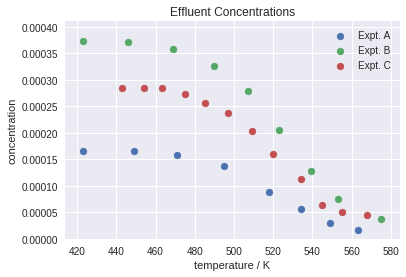

In [5]:
for expt in sorted(set(df.index)):
    plt.scatter(df['T'][expt], df['C'][expt])
    
plt.ylim(0, 1.1*max(df['C']))
plt.xlabel('temperature / K')
plt.ylabel('concentration')
plt.legend(["Expt. " + expt for expt in sorted(set(df.index))])
plt.title('Effluent Concentrations');

An initial plot of the data shows the effluent concentration decreases at higher operating temperatures. This indicates higher conversion at higher temperatures. A plot of conversion `X`

\begin{align*}
X & = \frac{C_0 - C}{C_0}
\end{align*}

collapses the data into a what appears to be a single function of temperature. The following cell adds conversion as an additional column of the data set.

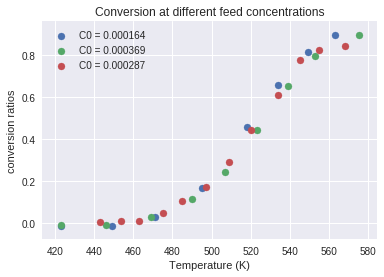

In [6]:
# add a column 'X' to the dataframe
df['X'] = 1 - df['C']/df['C0']

for expt in sorted(set(df.index)):
    plt.scatter(df['T'][expt], df['X'][expt])

plt.xlabel('Temperature (K)')
plt.ylabel('conversion ratios')
plt.legend(['C0 = ' + str(list(df['C0'][expt])[0]) for expt in sorted(set(df.index))])
plt.title('Conversion at different feed concentrations');

## Step 2. Select a Model

A proposed steady-state model for the catalytic reactor is

\begin{align*}
0 & = (C_0 - C) - \frac{m}{q} k_0 C^n\left(\frac{T}{T_r}\right)^n e^{-\frac{E_a}{R T_r }\frac{T_r}{T}}
\end{align*}

The known parameters are the flow rate $q$, the mass of catalysit $m$, and a reference temperature $T_r$. The ratio $\frac{T}{T_r}$ is the 'reduced temperature' and provides for a better conditioned equation. The unknown parameters are the reaction order $n$, the Arrhenius pre-exponental factor $k_0$, and the reduced activation energy $\frac{E_a}{R T_r}$. Generally the pre-exponential factor is very large, therefore is combined within the exponential term as $\ln k_0$.

\begin{align*}
0 & = (C_0 - C) - \frac{m}{q} C^n\left(\frac{T}{T_r}\right)^n e^{\ln k_0-\frac{E_a}{R T_r }\frac{T_r}{T}}
\end{align*}

The unknown parameters are:

|  <p align="left"> Parameter |  <p align="left"> Code |  <p align="left"> Description 
| :-------: | --: |
|  <p align="left"> $n$ |  <p align="left"> `n` | <p align="left"> reaction order 
|  <p align="left"> $\ln k_0$ | <p align="left"> `lnk0`| natural log of Arrenhius pre-exponential factor 
|  <p align="left"> $\frac{E_a}{R T_r}$ | <p align="left"> `ERTr` | <p align="left"> reduced activation energy 

## Step 3. Define a "figure of merit"

Each experimental measure consists of values of the unknown parameters and experimental values $C_{0,k}$, $T_k$, and $C_k$. Given estimates for the unknown parameters, the model equation provides a convenient definition of a residual $r_k$ as

\begin{align*}
r_k & = C_{0,k} - C_k - \frac{m}{q} C^n\left(\frac{T_k}{T_r}\right)^n e^{\ln k_0-\frac{E_a}{R T_r }\frac{T_r}{T_k}}
\end{align*}

If the model is an accurate depiction of the reaction processes then we expect the residuals to be small, random variates.

In [0]:
Tr = 298    # reference temperature.
q = 0.1     # flow rate (liters/min)
m = 1       # amount of catalyst (g)

def residuals(parameters, df):
    n, lnk0, ERTr = parameters
    C0, C, T = df['C0'], df['C'], df['T']
    return C0 - C - (m/q) * C**n  * (T/Tr)**n * np.exp(lnk0 - ERTr*Tr/T)

To illustrate, the following cell calculates the residuals for an initial estimate for the unknown parameter values. The residuals are then plotted as a function of the experimental variables to see if the residuals behave as random variates.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcfe2535668>,
      dtype=object)

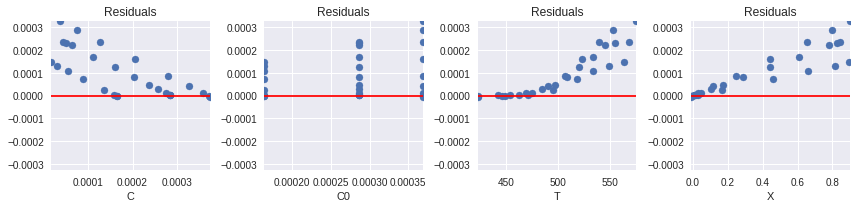

In [8]:
parameter_names = ['n', 'lnk0', 'ERTr']
parameter_guess = [1, 15, 38]

def plot_residuals(r, df, ax=None):
    rmax = np.max(np.abs(r))
    if ax is None:
        fig, ax = plt.subplots(1, len(df.columns), figsize=(12,3))
    else:
        rmax = max(ax[0].get_ylim()[1], rmax)
    n = 0
    for c in df.columns:
        ax[n].scatter(df[c], r)
        ax[n].set_ylim(-rmax, rmax)
        ax[n].set_xlim(min(df[c]), max(df[c]))
        ax[n].plot(ax[n].get_xlim(), [0,0], 'r')
        ax[n].set_xlabel(c)
        ax[n].set_title('Residuals') 
        n += 1
    plt.tight_layout()
    return ax

r = residuals(parameter_guess, df)
plot_residuals(r, df)

## Step 4. Find a Best Fit

A least squares 'figure of merit' for the fit of the model to the experimental data is given by

\begin{align*}
SOS & = \sum_k r_k^2
\end{align*}

Our goal is to find values for the unknown parameters that minimize the sum of the squares of the residuals.

The following cell defines two functions. The first is `sos` which calculates the sum of squares of the residuals. The `best_fit` function uses `scipy.optimize.fmin`

In [9]:
from scipy.optimize import fmin

def sos(parameters, df):
    return sum(r**2 for r in residuals(parameters, df))

def best_fit(fcn, df, disp=1):
    return fmin(fcn, parameter_guess, args=(df,), disp=disp)

parameter_fit = best_fit(sos, df)

for name,value in zip(parameter_names, parameter_fit):
    print(name, " = ", round(value,2))

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 140
         Function evaluations: 257
n  =  0.65
lnk0  =  13.65
ERTr  =  34.21


Let's compare how the residuals have been reduced as a result of minimizing the sum of squares.

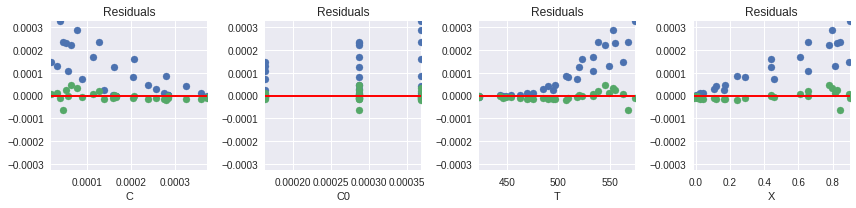

In [10]:
ax = plot_residuals(residuals(parameter_guess, df), df)
plot_residuals(residuals(parameter_fit, df), df, ax=ax);

## Step 5. Evaluate the Goodness of Fit

### Plotting Residuals

An important element of any parameter fitting exercise is to examine the residuals for systematic errors. The following cell plots the residuals as functions of .

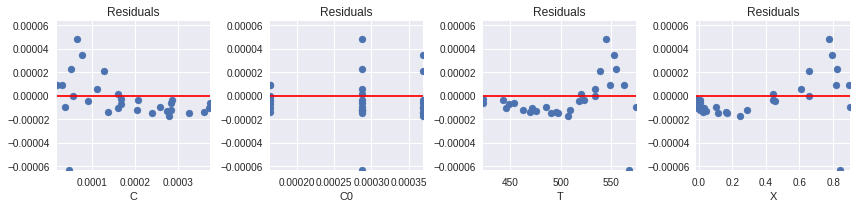

In [11]:
r = residuals(parameter_fit, df)
plot_residuals(r, df);

It's apparent that there is systematic error in the residuals.  To cause the minimizer to put more weight on those large residuals, a scaling factor is introduced into the norm used to measure the residual for the purpose of parameter estimation.

### Separable Model

An interesting feature of the model for the catalytic reactor is that it can be separated into two sides such that the right-hand side is a function only of $T$. 

\begin{align*}
\frac{C_{0} - C}{C^n} & = \frac{m}{q} \left(\frac{T}{T_r}\right)^n e^{\ln k_0 -\frac{E_a}{R T_r }\frac{T_r}{T}}
\end{align*}

Note that the left-hand side is a function of two independent experimental variables. But if the model accurately represents experimental behavior, then a plot of the left-hand side versus temperature should collapse to a single curve.

The next cell plots the experimental data as pairs $(x_k, y_k)$ where 

\begin{align*}
x_k & = \frac{C_{0,k} - C_k}{C_k^n}\\
y_k & = \frac{m}{q} \left(\frac{T_k}{T_r}\right)^n e^{\ln k_0 -\frac{E_a}{R T_r }\frac{T_r}{T_k}}\\
\end{align*}

If the fitted model is an accurate representation of the catalytic reactor, then the data should collapse to single curve aligned with diagonal.

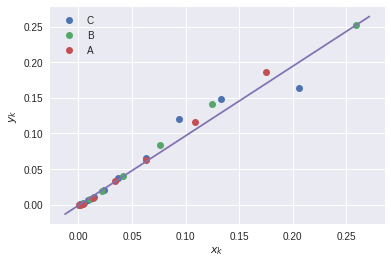

In [12]:
n, lnk0, ERTr = parameter_fit
for expt in set(df.index):
    y = (df['C0'][expt] - df['C'][expt])/df['C'][expt]**n
    x = (m/q) * (df['T'][expt]/Tr)**n * np.exp(lnk0 - ERTr*Tr/df['T'][expt])
    plt.plot(x, y, marker='o', lw=0)
plt.plot(plt.xlim(), plt.ylim())
plt.ylabel('$y_k$')
plt.xlabel('$x_k$')
plt.legend(set(df.index));

Substituting $C = C_0(1-X)$

\begin{align*}
\frac{X}{(1-X)^n}\frac{1}{C_0^{n-1}} & = \frac{m}{q} \left(\frac{T}{T_r}\right)^n e^{\ln k_0 -\frac{E_a}{R T_r }\frac{T_r}{T}}
\end{align*}

Text(0.5,0,'')

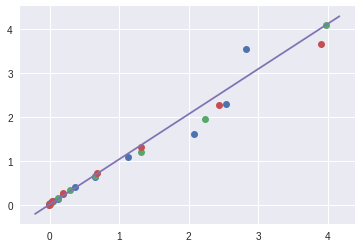

In [13]:
for expt in set(df.index):
    y = df['C0'][expt]**(n-1) * (m/q) * (df['T'][expt]/Tr)**n * np.exp(lnk0 - ERTr*Tr/df['T'][expt])
    x = df['X'][expt]/(1 - df['X'][expt])**n
    plt.plot(x, y, marker='o', lw=0)
plt.plot(plt.xlim(), plt.ylim())
plt.xlabel('')

## Step 6. Estimate Confidence Intervals

The following cell implements a simple bootstrap method for estimating confidence intervals for the fitted parameters. The function `resample` creates a new dataframe of data by sampling (with replacement) the original experimental data. 

The `best_fit` function is called `N` times on resampled data sets to create a statistical sample of fitted parameters. Those results are analyzed using statistical functions from the Pandas library.

In [0]:
from random import choices

def resample(df):
    return df.iloc[choices(range(0, len(df)), k=len(df))]

N = 100
dp = pd.DataFrame([best_fit(sos, resample(df), disp=0) for k in range(0,N)], columns=parameter_names)

Mean values and 95% confidence interval
n  =  0.67  +/-  0.2
lnk0  =  14.23  +/-  5.34
ERTr  =  35.02  +/-  6.86


Quantiles


,0.05,0.5,0.95
n,0.528570,0.652235,0.825784
lnk0,10.370035,13.788439,18.946778
ERTr,30.430791,34.260671,41.794342


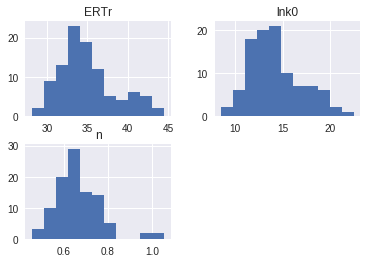

In [15]:
print('Mean values and 95% confidence interval')
for p in dp.columns:
    print(p, " = ", round(dp[p].mean(),2), " +/- ", round(1.96*dp[p].std(),2))

dp.hist(bins=1+int(np.sqrt(N)))
print("\n\nQuantiles")
dp.quantile([0.05, .5, 0.95]).T

## Step 7. Determine if a Better Fit is Possible

In this section we introduce an alternative method of coding solutions to parameter estimation problems using Pyomo. An advantage of using Pyomo is the more explicit indentification of unknown parameters, objective, and constraints on parameter values.

### Pyomo Model - Version 1

The first version of a Pyomo model for estimating parameters for the catalytic reactor is a direct translation of the approach outlined above. There are some key coding considerations in performing this translation to a Pyomo model:

* As of the current version of Pyomo, an optimization variable cannot appear in the exponent of an expresson. The workaound is to recognize $$ C^n = e^{n \ln C}$$
* The residuals are expressed as a list of Pyomo expressions.

n  =  0.65
lnk0  =  13.65
ERTr  =  34.21


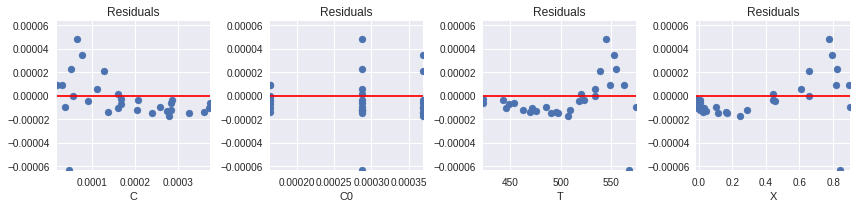

In [16]:
from pyomo.environ import *

Tr = 298    # The reference temperature.
q = 0.1     # The flow rate (liters/min)
m = 1       # The amount of catalyst (g)

def pyomo_fit1(df):
    T  = list(df['T'])
    C  = list(df['C'])
    C0 = list(df['C0'])

    mdl = ConcreteModel()
    mdl.n    = Var(domain=Reals, initialize=1)
    mdl.lnk0 = Var(domain=Reals, initialize=15)
    mdl.ERTr = Var(domain=Reals, initialize=38)
    
    residuals = [
        C0[k] - C[k] - (m/q) * exp(mdl.n*log(C[k])) * exp(mdl.n*log(T[k]/Tr)) * exp(mdl.lnk0 - mdl.ERTr*Tr/T[k])
        for k in range(len(C))]

    mdl.obj = Objective(expr=sum(residuals[k]**2 for k in range(len(C))), sense=minimize)
    SolverFactory('ipopt', executable=ipopt_executable).solve(mdl)
    return [mdl.n(), mdl.lnk0(), mdl.ERTr()], [residuals[k]() for k in range(len(C))]

parameter_values_1, r1 = pyomo_fit1(df)
plot_residuals(r1, df)
for name,value in zip(parameter_names, parameter_values_1):
    print(name, " = ", round(value,2))

### Pyomo Model - Version 2

As a second model we consider a somewhat simpler model that omits the temperature dependence of the Arrhenius pre-exponential factor:

\begin{align*}
0 & = C_0 - C - \frac{m}{q} C^n e^{\ln k_0-\frac{E_a}{R T_r }\frac{T_r}{T}}
\end{align*}

Can this somewhat simpler model adequately fit the data?

n  =  0.65
lnk0  =  14.69
ERTr  =  35.4


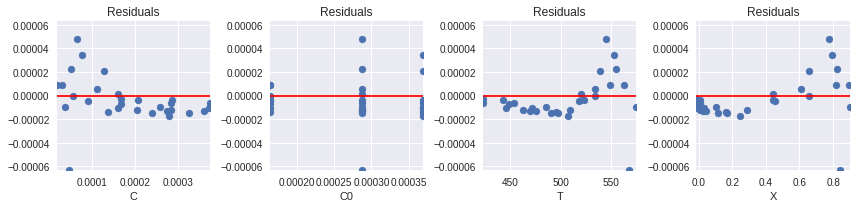

In [17]:
from pyomo.environ import *

Tr = 298    # The reference temperature.
q = 0.1     # The flow rate (liters/min)
m = 1       # The amount of catalyst (g)

def pyomo_fit2(df):
    T  = list(df['T'])
    C  = list(df['C'])
    C0 = list(df['C0'])

    mdl = ConcreteModel()
    mdl.n    = Var(domain=Reals, initialize=1)
    mdl.lnk0 = Var(domain=Reals, initialize=15)
    mdl.ERTr = Var(domain=Reals, initialize=38)
    
    residuals = [
        C0[k] - C[k] - (m/q) * exp(mdl.n*log(C[k])) * exp(mdl.lnk0 - mdl.ERTr*Tr/T[k])
        for k in range(len(C))]

    mdl.obj = Objective(expr=sum(residuals[k]**2 for k in range(len(C))), sense=minimize)
    SolverFactory('ipopt', executable=ipopt_executable).solve(mdl)
    return [mdl.n(), mdl.lnk0(), mdl.ERTr()], [residuals[k]() for k in range(len(C))]

parameter_values_2, r2 = pyomo_fit2(df)
plot_residuals(r2, df)
for name,value in zip(parameter_names, parameter_values_2):
    print(name, " = ", round(value,2))

Is there a meaningful difference between these two models?

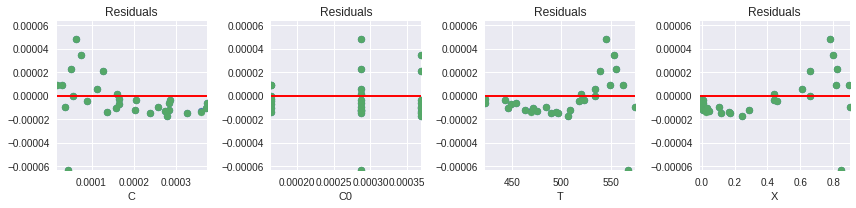

In [18]:
ax = plot_residuals(r2, df)
plot_residuals(r1, df, ax=ax);

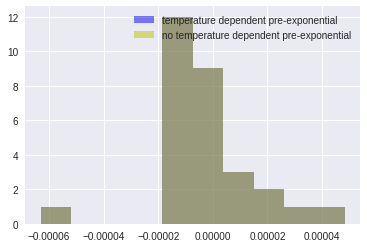

In [19]:
plt.hist(r1, color='b', alpha=0.5)
plt.hist(r2, color='y', alpha=0.5)
plt.legend(['temperature dependent pre-exponential', 'no temperature dependent pre-exponential'])

Based on this analysis of residuals, there is very little statistical support for a temperature dependent Arrhenius pre-exponential factor. Generally speaking, in situations like this it is generally wise to go with the simplist (i.e, most parsimonious) model that can adequately explain the data.

### Pyomo Model - Version 3

Is the reaction $n^{th}$ order, or could it be satisfactorily approximated with first-order kinetics?

\begin{align*}
0 & = C_0 - C - \frac{m}{q} C e^{\ln k_0-\frac{E_a}{R T_r }\frac{T_r}{T}}
\end{align*}

The following cell adds a constraint to force $n=1$. We'll then examine the residuals to test if there is a statistically meaningful difference between the case $n=1$ and $n \ne 1$.

n  =  1.0
lnk0  =  23.01
ERTr  =  44.59


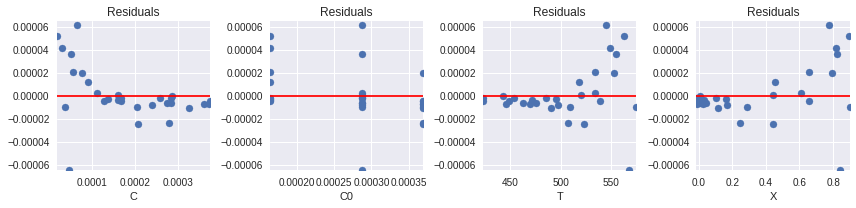

In [20]:
from pyomo.environ import *

Tr = 298    # The reference temperature.
q = 0.1     # The flow rate (liters/min)
m = 1       # The amount of catalyst (g)

def pyomo_fit3(df):
    T  = list(df['T'])
    C  = list(df['C'])
    C0 = list(df['C0'])

    mdl = ConcreteModel()
    mdl.n    = Var(domain=Reals, initialize=1)
    mdl.lnk0 = Var(domain=Reals, initialize=15)
    mdl.ERTr = Var(domain=Reals, initialize=38)
    
    residuals = [
        C0[k] - C[k] - (m/q) * exp(mdl.n*log(C[k])) * exp(mdl.lnk0 - mdl.ERTr*Tr/T[k])
        for k in range(len(C))]

    mdl.obj = Objective(expr=sum(residuals[k]**2 for k in range(len(C))), sense=minimize)
    mdl.con = Constraint(expr = mdl.n==1)
    SolverFactory('ipopt', executable=ipopt_executable).solve(mdl)
    return [mdl.n(), mdl.lnk0(), mdl.ERTr()], [residuals[k]() for k in range(len(C))]

parameter_values_3, r3 = pyomo_fit3(df)
plot_residuals(r3, df)
for name,value in zip(parameter_names, parameter_values_3):
    print(name, " = ", round(value, 2))

Comparing to models above, we see that restricting $n=1$ does lead to somewhat larger residuals.

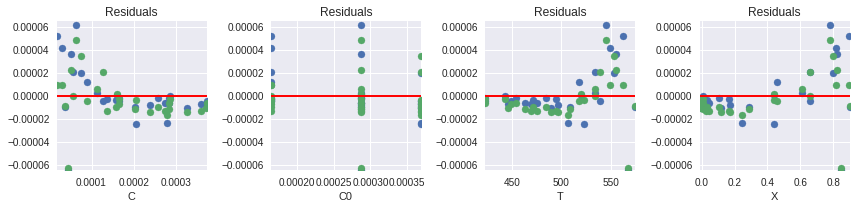

In [21]:
ax = plot_residuals(r3, df)
plot_residuals(r2, df, ax=ax);

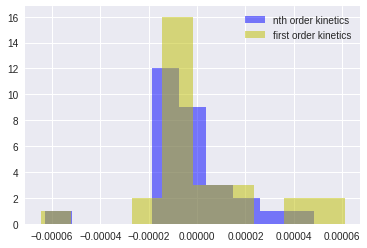

In [22]:
plt.hist(r2, color='b', alpha=0.5)
plt.hist(r3, color='y', alpha=0.5)
plt.legend(['nth order kinetics', 'first order kinetics'])

#### F-ratio Test

In [23]:
from scipy.stats import f

r2 = np.array(r2)
df2 = len(r2) - 1 - 3  # degrees of freedom after fitting 3 parameters

r3 = np.array(r3)
df3 = len(r3) - 1 - 3  # degrees of freedom after fitting 2 parameters

Fratio = r2.var()/r3.var()

pvalue = f.cdf(Fratio, df2, df3)

if pvalue > 0.05:
    print("Cannot reject hypothesis that the variances are equal at p=0.05: Test pvalue = ", pvalue)

Cannot reject hypothesis that the variances are equal at p=0.05: Test pvalue =  0.13297014615599262


#### Levene Test

The [Levene test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html) provides a more robust test for the null hypothesis that samples are from populations with equal variances. 

In [24]:
from scipy.stats import levene
levene(r2, r3)

LeveneResult(statistic=0.34495202886490245, pvalue=0.5593454146853113)

The Levene statistic means that we cannot rule out that the residuals of these models have different variances. Consequently we do not have statistically meaningful evidence that the order of the reaction is different from $n=1$.

<!--NAVIGATION-->
< [Parameter Estimation](http://nbviewer.jupyter.org/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/07.00-Parameter-Estimation.ipynb) | [Contents](toc.ipynb) | [Financial Applications](http://nbviewer.jupyter.org/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/08.00-Financial-Applications.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/07.01-Parameter-Estimation-Catalytic-Reactor.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>